In [2]:
import numpy as np
import matplotlib.pyplot as pl
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.integrate import quadrature as quad
from scipy import special

r_unit = 300 #kpc
m_unit = 1e12 #solar masses
v_unit = 120 #km/s
rho_unit = 3.7e4 #solar masses per cubic kiloparsec
sigma_unit = 1.1e7 #solar masses per square kiloparsec

num_particles = 100000
total_mass = 1
particle_mass = total_mass/num_particles

# 3.1 The Pendulum Revisited

In [3]:
# Euler method
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, fixed

def pendulum(theta0, omega0, L=4, g=9.81, tfinal=12, dt=0.01):
    npoints = int(tfinal / dt) + 1
    t = np.linspace(0, tfinal, npoints)
    theta = np.zeros(npoints)
    omega = np.zeros(npoints)
    theta[0] = theta0
    omega[0] = omega0

    for n in range(npoints - 1):
        omega[n + 1] = omega[n] - (g / L) * np.sin(theta[n]) * dt
        theta[n + 1] = theta[n] + omega[n + 1] * dt
    theta_exact = theta0 * np.cos(np.sqrt(g / L) * t)

    pl.plot(t, theta_exact, 'r', label='Exact solution')
    pl.plot(t, theta, '.', label="Euler's method")
    pl.xlabel('Time')
    pl.ylabel('Theta')
    pl.legend()
    pl.grid(True)
    pl.show()

interact(pendulum, theta0=(0, np.pi/2), omega0=(0, 3), L=fixed(4), g=fixed(9.81), tfinal=(12), dt=(0.1, 0.2, 0.001))

interactive(children=(FloatSlider(value=0.7853981633974483, description='theta0', max=1.5707963267948966), Int…

<function __main__.pendulum(theta0, omega0, L=4, g=9.81, tfinal=12, dt=0.01)>

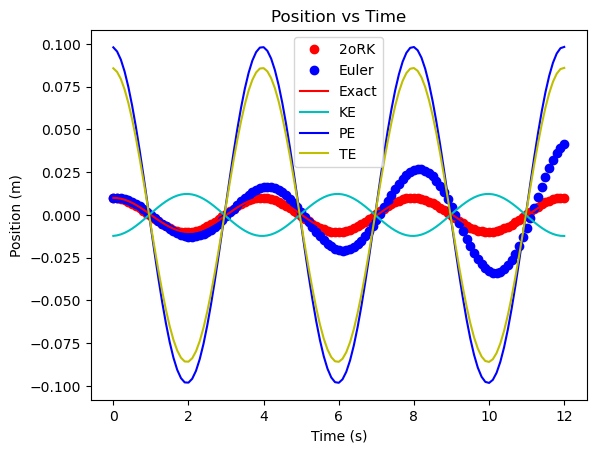

In [4]:
# Runge Kutta
g=9.8
L=4
tfinal=12
dt=0.1
w0=0
theta0=0.01
m=1 #kg
t = np.arange(0.,tfinal+dt,dt)
npoints = len(t)

thetaE = np.zeros(npoints)
wE = np.zeros(npoints)

theta_exact=theta0*np.cos(np.sqrt(g/L)*t)

thetaE[0]=theta0
wE[0]=w0

for i in range(npoints-1):
    thetaE[i+1]=thetaE[i]+wE[i]*dt
    wE[i+1]=wE[i]-(g/L*np.sin(thetaE[i]))*dt


theta = np.zeros(npoints)
w = np.zeros(npoints)

theta[0]=0.01
w[0]=0

for i in range(npoints-1):
    thetamid=theta[i]+w[i]*dt/2
    wmid=w[i]-(g/L*np.sin(theta[i]))*dt
    theta[i+1]=theta[i]+wmid*dt
    w[i+1]=w[i]-((g/L*np.sin(theta[i]))*dt)
    KE=(1/2)*m*(-g/L*np.sin(theta))
    PE=m*g*theta
    TE=KE+PE
    

    
pl.figure(1)
pl.plot(t,theta,'ro',label='2oRK')
pl.plot(t,thetaE,'bo',label='Euler')
pl.plot(t,theta_exact,'r-',label='Exact')
pl.plot(t,KE,'c',label='KE')
pl.plot(t,PE,'b',label='PE')
pl.plot(t,TE,'y',label='TE')
pl.legend()
pl.xlabel('Time (s)')
pl.ylabel('Position (m)')
pl.title('Position vs Time')
pl.show()



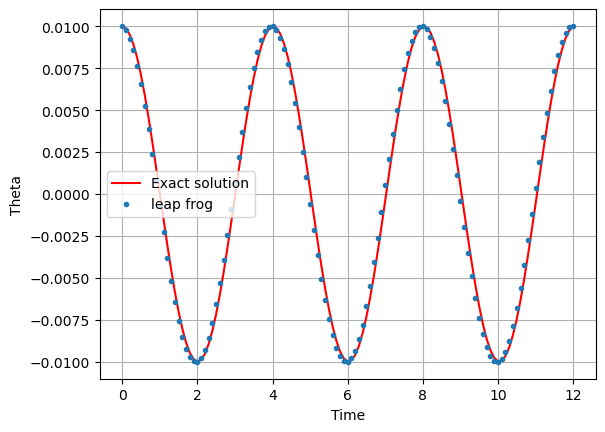

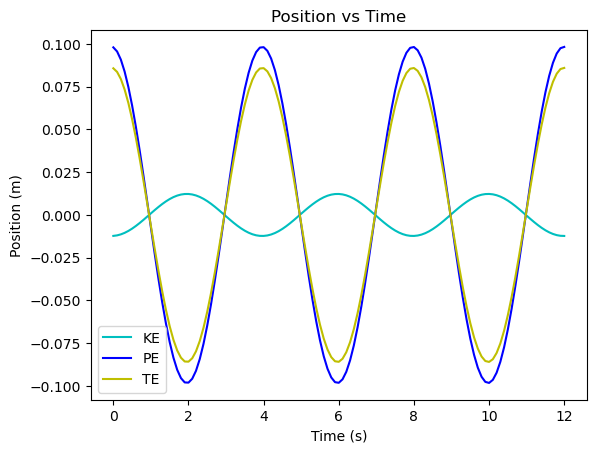

In [5]:
# leapforg method
def derivs(y, t):
        r, theta, phi, v_r, v_theta, v_phi = y
        # Compute gravitational force based on the NFW potential
        force = -rho(r) * r**2 / particle_mass

        # Equations of motion for circular orbits
        drdt = v_r
        dthetadt = v_theta / r
        dphidt = v_phi / (r * np.sin(theta))
        dv_rdt = force / particle_mass
        dv_thetadt = 0  # Circular orbit
        dv_phidt = 0    # Circular orbit

def leapfrog_step(theta0, omega0, L=4, g=9.81, tfinal=12 ,dt=0.1):
    # Perform a single leapfrog integration step
    half_dt = 0.5 * dt

    # Update velocities at half time step
    theta0[3:] += half_dt * omega0(theta0, t)[3:]

    # Update positions at full time step
    theta0[:3] += dt * theta0[3:]

    # Update velocities at full time step
    theta0[3:] += half_dt * derivs(theta0, t + dt)[3:]

    return theta0

for i in range(npoints-1):
    KE=(1/2)*m*(-g/L*np.sin(theta))
    PE=m*g*theta
    TE=KE+PE

pl.plot(t, theta_exact, 'r', label='Exact solution')
pl.plot(t, theta, '.', label="leap frog")
pl.xlabel('Time')
pl.ylabel('Theta')
pl.legend()
pl.grid(True)
pl.show()

pl.figure(1)
pl.plot(t,KE,'c',label='KE')
pl.plot(t,PE,'b',label='PE')
pl.plot(t,TE,'y',label='TE')
pl.legend()
pl.xlabel('Time (s)')
pl.ylabel('Position (m)')
pl.title('Position vs Time')
pl.show()


# 3.2 Orbits in an NFW Halo

In [6]:
# code from project 2(from jeremy and jonna) to excute 3.2

#spherical: spherical coordinates in a numpy array (radius, elevation, azimuth)
#returns: cartesian corrdinates in a numpy array (x, y, z)
def spherical_to_cartesian(spherical):
  r = spherical[0]
  el = spherical[1]
  az = spherical[2]
  x = r*np.cos(az)*np.sin(el)
  y = r*np.sin(az)*np.sin(el)
  z = r*np.cos(el)
  return np.array([x,y,z])

#cartesian: cartesian coordinates in a numpy array (x, y, z)
#returns: spherical coordinates in a numpy array (radius, elevation, azimuth)
def cartesian_to_spherical(cartesian):
  x = cartesian[0]
  y = cartesian[1]
  z = cartesian[2]
  r = np.sqrt(x**2+y**2+z**2)
  el = np.arccos(z/r)
  az = np.arctan2(y,x)
  return np.array([r,el,az])

#cylindrical: cylindrical coordinates in a numpy array (radius, azimuth, z)
#returns: cartesian corrdinates in a numpy array (x, y, z)
def cylindrical_to_cartesian(cylindrical):
  r = cylindrical[0]
  az = cylindrical[1]
  z = cylindrical[2]
  x = r*np.cos(az)
  y = r*np.sin(az)
  return np.array([x,y,z])

#cartesian: cartesian coordinates in a numpy array (x, y, z)
#returns: cylindrical coordinates in a numpy array (radius, azimuth, z)
def cartesian_to_cylindrical(cartesian):
  x = cartesian[0]
  y = cartesian[1]
  z = cartesian[2]
  r = np.sqrt(x**2+y**2)
  az = np.arctan2(y,x)
  return np.array([r,az,z])



# acceptance/rejection method

def accept_reject(x_min, x_max, y_min, y_max, y, n):
  rng = np.random.default_rng()
  result = np.zeros(n)
  for i in range(n):
    x = rng.uniform(x_min, x_max)
    while rng.uniform(y_min, y_max) >= y(x):
      x = rng.uniform(x_min, x_max)
    result[i] = x
  return result

def accept_reject_batch(x_min, x_max, y_min, y_max, y, n):

  rng = np.random.default_rng()
  result = np.zeros(n)
  accepted = np.full(n, False)
  num_accepted = 0

  while num_accepted < n:
    x = rng.uniform(x_min, x_max, n)
    new_accepted_indices = np.intersect1d(np.where(accepted == False)[0],np.where(rng.uniform(y_min, y_max, n) < y(x))[0],assume_unique=True)
    num_accepted += len(new_accepted_indices)
    result[new_accepted_indices] = x[new_accepted_indices]
    accepted[new_accepted_indices] = True

  return result

#models from project 2(from Jeremy and Jonna)

def plot_model(ax,x,y,xlabel='',ylabel='',title='',xticks=None,yticks=None):
  ax.hist2d(x,y,bins=50,norm='log',cmap=plt.cm.jet)
  ax.set_aspect('equal')
  if xticks != None:
    ax.set_xticks(xticks)
  if yticks != None:
    ax.set_yticks(yticks)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
#----------------------------------------------------------------
def isothermal_model(num_particles):

  particle_mass = 1/num_particles
  particles = np.zeros((num_particles,6))
  rho_0 = 1/(4*np.pi)
  rho = lambda r : rho_0/(r**2)
  rng = np.random.default_rng()

  particles[:,2] = rng.uniform(0, 2*np.pi, num_particles)
  particles[:,1] = np.arccos(rng.uniform(-1,1,num_particles))
  particles[:,0] = rng.random(num_particles)
  particles[:,3] = rng.normal(0,1/(3**0.5),num_particles)
  particles[:,4] = rng.normal(0,1/(3**0.5),num_particles)
  particles[:,5] = rng.normal(0,1/(3**0.5),num_particles)

  return particles
#--------------------------------------------------------------
def nfw_model(num_particles):

  c = 15
  particle_mass = 1/num_particles
  particles = np.zeros((num_particles,6))
  rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
  rho = lambda r : rho_0/(c*r*(1+c*r)**2)
  rng = np.random.default_rng()

  particles[:,2] = rng.uniform(0, 2*np.pi, num_particles)
  particles[:,1] = np.arccos(rng.uniform(-1,1,num_particles))
  particles[:,0] = accept_reject_batch(0,1,0,rho(1/15),lambda r : 4*np.pi*r**2*rho(r),num_particles)

  nfw_velocity_table = np.loadtxt('NFW_dispersion.dat')
  velocity_interp = interp.interp1d(nfw_velocity_table[:,0],nfw_velocity_table[:,1],kind='linear',fill_value='extrapolate')
  velocity_dispersion = velocity_interp(particles[:,0])
  particles[:,3] = rng.normal(0,velocity_dispersion,num_particles)
  particles[:,4] = rng.normal(0,velocity_dispersion,num_particles)
  particles[:,5] = rng.normal(0,velocity_dispersion,num_particles)

  return particles
#--------------------------------------------------------
def exponential_disk_model1(num_particles):

  scaling_radius = 0.01
  particle_mass = 1/num_particles
  particles = np.zeros((num_particles,6))
  sigma_0 = 1/(2*np.pi*scaling_radius**2)
  sigma = lambda r : sigma_0*np.exp(-r/scaling_radius)
  rng = np.random.default_rng()

  particles[:,1] = rng.uniform(0,2*np.pi,num_particles)
  particles[:,0] = accept_reject_batch(0,0.05,0,50,lambda r : 2*np.pi*r*sigma(r),num_particles)
  particles[:,2] = rng.normal(0,0.001,num_particles)

  c = 100
  rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
  rho = lambda r : rho_0/(c*r*(1+c*r)**2)

  num_table_entries = 1000
  table_radii = np.linspace(0,0.05,num_table_entries)
  table_masses = np.zeros(num_table_entries)
  for i in range(1,num_table_entries):
    table_masses[i] = 4*np.pi*quad(lambda r : (r**2)*rho(r),0,table_radii[i])[0]
  table_velocities = np.zeros(num_table_entries)
  table_velocities[1:] = np.sqrt(table_masses[1:]/table_radii[1:])

  velocity_interp = interp.interp1d(table_radii,table_velocities,kind='linear',fill_value='extrapolate')

  particles[:,3] = 0.9995*velocity_interp(particles[:,0])+rng.normal(0,10/v_unit,num_particles)
  particles[:,4] = (particles[:,1]+0.5*np.pi)+rng.normal(0,10/v_unit,num_particles)
  particles[:,5] = rng.normal(0,5/v_unit,num_particles)
  for i in range(num_particles):
    if particles[i,4] >= 2*np.pi:
      particles[i,4] -= 2*np.pi

  '''
  r_smooth = np.linspace(0,0.05,1000)
  v_smooth = np.zeros(1000)
  actual_velocities = np.zeros(num_particles)
  for i in range(num_particles):
    actual_velocities[i] = velocity_interp(particles[i,0])
  plt.plot(particles[:,0],actual_velocities,'r.')
  for i in range(1000):
    v_smooth[i] = velocity_interp(r_smooth[i])
  plt.plot(r_smooth,v_smooth)
  plt.xlabel('Radius')
  plt.ylabel('Circular Velocity')
  plt.show()
  '''

  return particles, velocity_interp
#----------------------------------------
def exponential_disk_model2(num_particles):

  scaling_radius = 0.01
  mass_disk = 4e10/m_unit
  particle_mass = 1/num_particles
  particles = np.zeros((num_particles,6))
  sigma_0 = 1/(2*np.pi*scaling_radius**2)
  sigma = lambda r : sigma_0*np.exp(-r/scaling_radius)
  rng = np.random.default_rng()

  particles[:,1] = rng.uniform(0,2*np.pi,num_particles)
  particles[:,0] = accept_reject_batch(0,0.05,0,50,lambda r : 2*np.pi*r*sigma(r),num_particles)
  particles[:,2] = rng.normal(0,0.001,num_particles)

  '''
  c = 100
  rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
  rho = lambda r : rho_0/(c*r*(1+c*r)**2)

  num_table_entries = 1000
  table_radii = np.linspace(0,0.05,num_table_entries)
  table_masses = np.zeros(num_table_entries)
  for i in range(1,num_table_entries):
    table_masses[i] = 4*np.pi*quad(lambda r : (r**2)*rho(r),0,table_radii[i])[0]
  table_velocities = np.zeros(num_table_entries)
  table_velocities[1:] = np.sqrt(table_masses[1:]/table_radii[1:])
  '''

  velocity_interp = lambda r : np.sqrt(mass_disk*r**2/(2*scaling_radius**3)*(special.i0(r/(2*scaling_radius))*special.k0(r/(2*scaling_radius))-special.i1(r/(2*scaling_radius))*special.k1(r/(2*scaling_radius))))

  particles[:,3] = 0.9995*velocity_interp(particles[:,0])+rng.normal(0,10/v_unit,num_particles)
  particles[:,4] = (particles[:,1]+0.5*np.pi)+rng.normal(0,10/v_unit,num_particles)
  particles[:,5] = rng.normal(0,5/v_unit,num_particles)
  for i in range(num_particles):
    if particles[i,4] >= 2*np.pi:
      particles[i,4] -= 2*np.pi

  '''
  r_smooth = np.linspace(0,0.05,1000)
  v_smooth = np.zeros(1000)
  actual_velocities = np.zeros(num_particles)
  for i in range(num_particles):
    actual_velocities[i] = velocity_interp(particles[i,0])
  plt.plot(particles[:,0],actual_velocities,'r.')
  for i in range(1000):
    v_smooth[i] = velocity_interp(r_smooth[i])
  plt.plot(r_smooth,v_smooth)
  plt.xlabel('Radius')
  plt.ylabel('Circular Velocity')
  plt.show()
  '''

  return particles, velocity_interp
#--------------------------------------------------------
def exponential_disk_model3(num_particles):

  scaling_radius = 0.01
  mass_disk = 4e10/m_unit
  particle_mass = 1/num_particles
  particles = np.zeros((num_particles,6))
  sigma_0 = 1/(2*np.pi*scaling_radius**2)
  sigma = lambda r : sigma_0*np.exp(-r/scaling_radius)
  rng = np.random.default_rng()

  particles[:,1] = rng.uniform(0,2*np.pi,num_particles)
  particles[:,0] = accept_reject_batch(0,0.05,0,50,lambda r : 2*np.pi*r*sigma(r),num_particles)
  particles[:,2] = rng.normal(0,0.001,num_particles)

  c = 15
  rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
  rho = lambda r : rho_0/(c*r*(1+c*r)**2)

  num_table_entries = 1000
  table_radii = np.linspace(0,0.05,num_table_entries)
  table_masses = np.zeros(num_table_entries)
  for i in range(1,num_table_entries):
    table_masses[i] = 4*np.pi*quad(lambda r : (r**2)*rho(r),0,table_radii[i])[0]
  table_square_velocities = np.zeros(num_table_entries)
  table_square_velocities[1:] = table_masses[1:]/table_radii[1:]

  square_velocity_interp1 = interp.interp1d(table_radii,table_square_velocities,kind='linear',fill_value='extrapolate')
  square_velocity_interp2 = lambda r : mass_disk*r**2/(2*scaling_radius**3)*(special.i0(r/(2*scaling_radius))*special.k0(r/(2*scaling_radius))-special.i1(r/(2*scaling_radius))*special.k1(r/(2*scaling_radius)))

  velocity_interp = lambda r : np.sqrt(square_velocity_interp1(r)+square_velocity_interp2(r))

  particles[:,3] = 0.9995*velocity_interp(particles[:,0])+rng.normal(0,10/v_unit,num_particles)
  particles[:,4] = (particles[:,1]+0.5*np.pi)+rng.normal(0,10/v_unit,num_particles)
  particles[:,5] = rng.normal(0,5/v_unit,num_particles)
  for i in range(num_particles):
    if particles[i,4] >= 2*np.pi:
      particles[i,4] -= 2*np.pi

  '''
  r_smooth = np.linspace(0,0.05,1000)
  v_smooth = np.zeros(1000)
  actual_velocities = np.zeros(num_particles)
  for i in range(num_particles):
    actual_velocities[i] = velocity_interp(particles[i,0])
  plt.plot(particles[:,0],actual_velocities,'r.')
  for i in range(1000):
    v_smooth[i] = velocity_interp(r_smooth[i])
  plt.plot(r_smooth,v_smooth)
  plt.xlabel('Radius')
  plt.ylabel('Circular Velocity')
  plt.show()
  '''

  return particles, velocity_interp

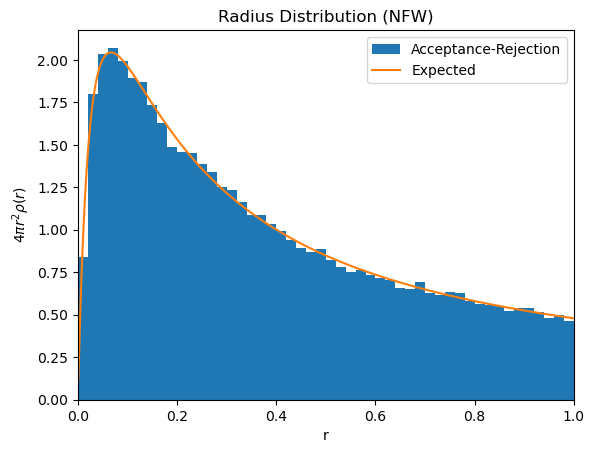

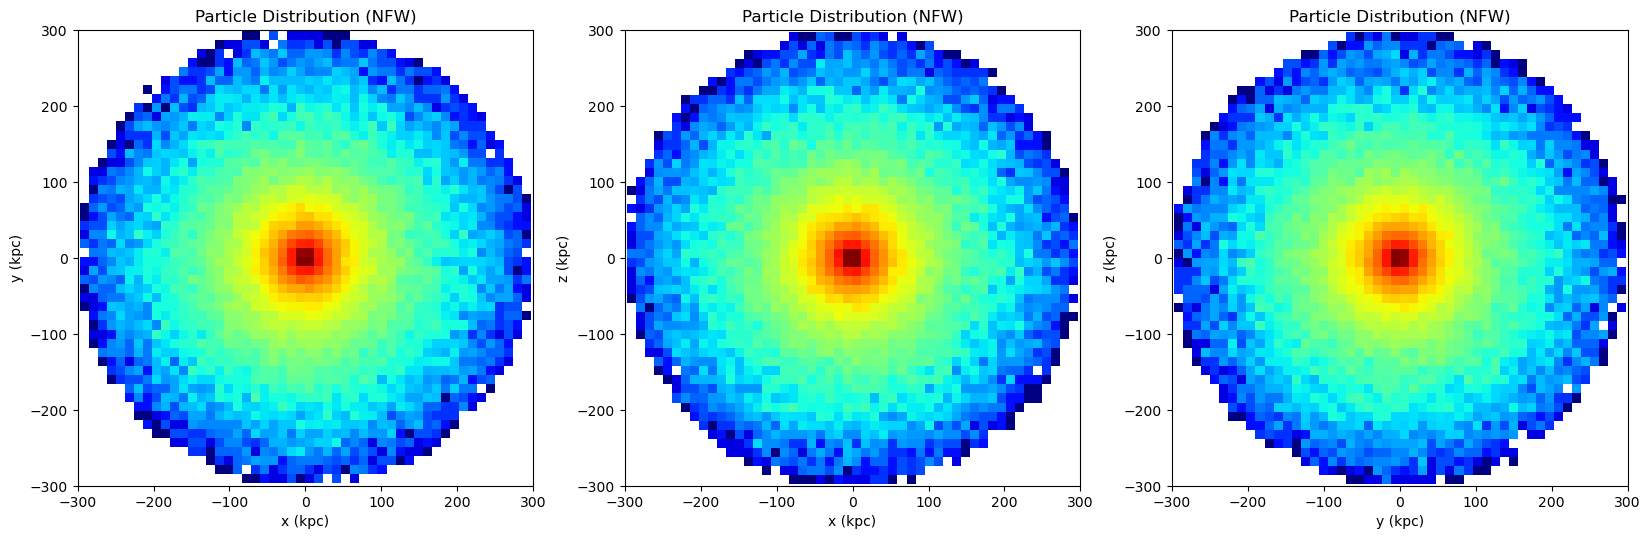

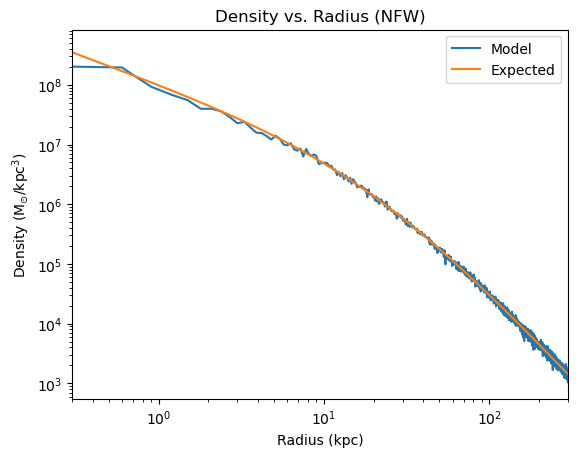

Kinetic Energy: 5.1594e+52 J
Potential Energy: -9.7743e+52 J
2T/|W| = 1.0557087667997147


In [7]:
#NFW model
c = 15
rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
rho = lambda r : rho_0/(c*r*(1+c*r)**2)
phi = lambda r : -(4*np.pi*rho_0*np.log(1+c*r))/(c**3*r)

particles = nfw_model(num_particles)
spherical = particles[:,0:3]
velocities = particles[:,3:]
square_velocities = velocities[:,0]**2+velocities[:,1]**2+velocities[:,2]**2
cartesian = np.zeros((num_particles,3))
for i in range(num_particles):
  cartesian[i] = spherical_to_cartesian(spherical[i])
scaled_cartesian = cartesian*r_unit

num_bins = 1000
r_smooth = np.linspace(0,1,num_bins)[1:]

plt.hist(spherical[:,0],50,density=True,label='Acceptance-Rejection')
plt.plot(r_smooth,4*np.pi*r_smooth**2*rho(r_smooth),label='Expected')
plt.xlim((0,1))
plt.xlabel('r')
plt.ylabel(r'$4 \pi r^2 \rho (r)$')
plt.title('Radius Distribution (NFW)')
plt.legend()
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,8))
plot_model(ax1,scaled_cartesian[:,0],scaled_cartesian[:,1],'x (kpc)','y (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plot_model(ax2,scaled_cartesian[:,0],scaled_cartesian[:,2],'x (kpc)','z (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plot_model(ax3,scaled_cartesian[:,1],scaled_cartesian[:,2],'y (kpc)','z (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plt.show()

shell_densities = np.zeros(num_bins)
bins = np.linspace(0,1,num_bins+1)
radii = spherical[:,0]
for i in range(num_bins):
  inner_radius = bins[i]
  outer_radius = bins[i+1]
  num_particles_in_shell = len(np.where(radii[np.where(radii < outer_radius)[0]] >= inner_radius)[0])
  shell_densities[i] = num_particles_in_shell*particle_mass/(4/3*np.pi*(outer_radius**3-inner_radius**3))
scaled_shell_densities = shell_densities*rho_unit

plt.loglog(bins[:-1]*r_unit,scaled_shell_densities,label='Model')
plt.loglog(r_smooth*r_unit,rho(r_smooth)*rho_unit,label='Expected')
plt.xlim((bins[1]*r_unit,r_unit))
plt.xlabel('Radius (kpc)')
plt.ylabel('Density (M$_{\odot}$/kpc$^3$)')
plt.title('Density vs. Radius (NFW)')
plt.legend()
plt.show()

kinetic_energy = 0.5*particle_mass*m_unit*np.sum(square_velocities)*v_unit**2
potential_energy = particle_mass*m_unit*np.sum(phi(spherical[:,0]))*v_unit**2

print('Kinetic Energy: %.4e J'%(kinetic_energy*1.99e36))
print('Potential Energy: %.4e J'%(potential_energy*1.99e36))
print('2T/|W| = '+str(2*kinetic_energy/abs(potential_energy)))

0.7129288257845388


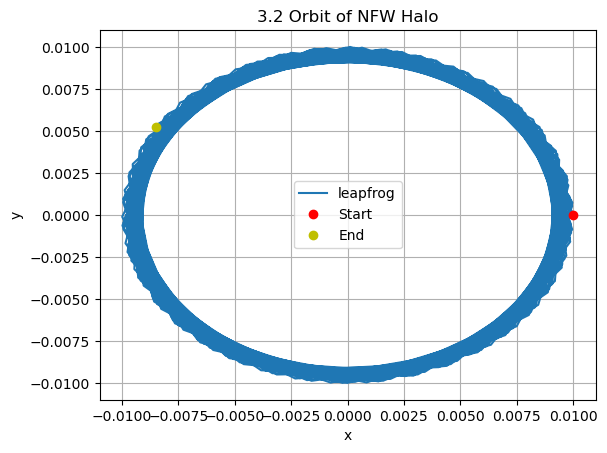

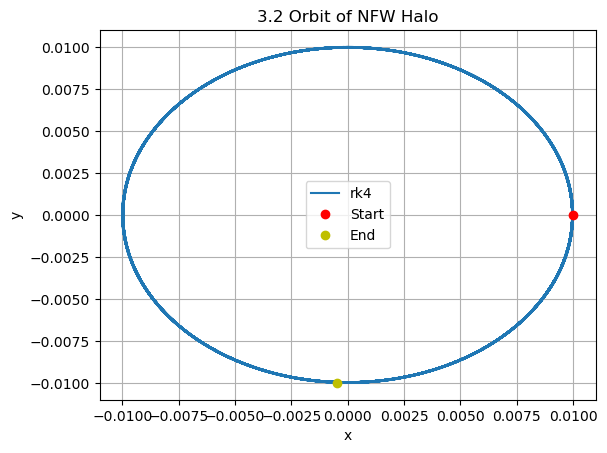

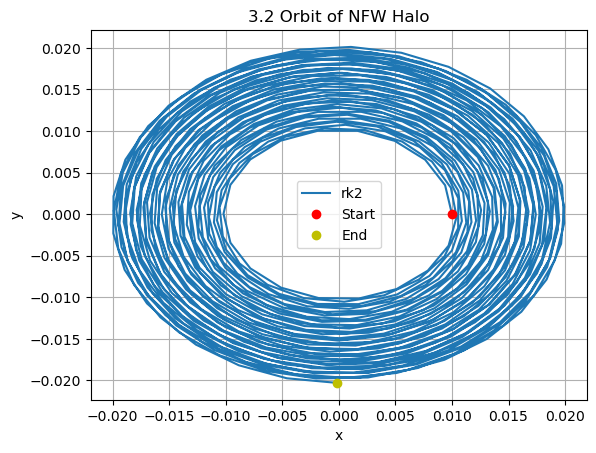

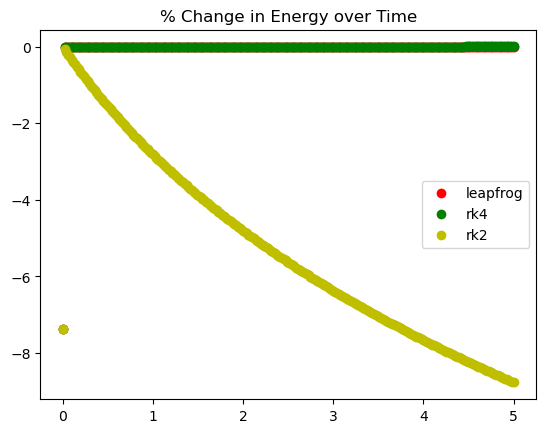

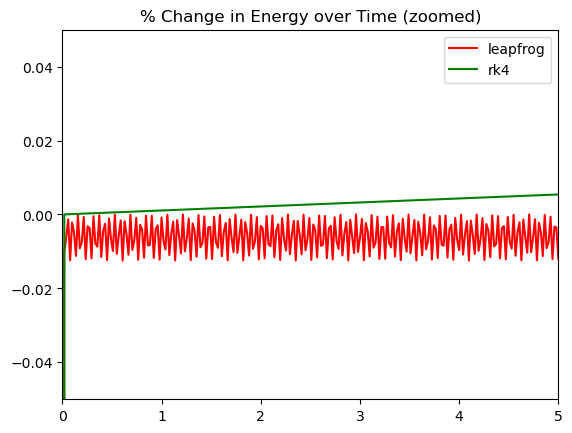

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp1d
from scipy.integrate import quadrature as quad
from scipy import special
from numpy.random import RandomState

r = RandomState()

def create_NFW(MASS=1.,RADIUS=1.,NUMPART=100000,const_C=15.,graph=True,mass_dist=False):
  '''
  Create an NFW spherical dark matter halo
  depends on MASS, RADIUS, and NUMPART (number of particles).
  '''

  ####### SETUP ################
  # Instead of using rs to characterize an NFW model, one typically uses the concentration c ≡ Rvir/rs
  # Simulations show that c scales with the dark matter halo mass and ranges from a few up to 30 or so.
  # For a Milky Way mass halo c ≈ 15. Using this definition and using units where Rvir = 1
  const_P0 = (const_C**3/(4*np.pi))*((np.log(1+const_C)-(const_C/(1+const_C)))**-1)
  particle_info = np.zeros((NUMPART,7))      # format is [[mass, x,y,z, vx,vy,vz],[particle 2 data], [etc]]
  part_mass = MASS/NUMPART
  # set particle masses
  particle_info[:,0] = part_mass

  ## lamda funcions
  p_r = lambda r: const_P0/((const_C*r)*((1+const_C*r)**2))
  pot_r = lambda r: (-4*np.pi*const_P0/(const_C**3))*(np.log(1+const_C*r)/r)

 
  # then we just need to find the radius from center, which is based on the density function given to us
  radius_dist = np.zeros(NUMPART)

  ## RADIUS DISTRIBUTION ##
  r = RandomState()
  xmin = 0
  xmax = RADIUS
  ymin = 0 # can be arbitrarily set to 0 here bc radius is never <0
  f = lambda x: 4*np.pi*(x**2)*p_r(x)
  iteration_check = np.linspace(xmin,xmax,100) # check 100 times what the max of the function is for ymax
  check = f(iteration_check[1:])
  ymax = np.max(check)
  
  yrand = (ymax-ymin)*r.rand(NUMPART*10)+ymin # make numpart*3 number of random numbers, so that we for sure have numpart # of particles within the boundary
  xrand = (xmax-xmin)*r.rand(NUMPART*10)+xmin
  ind = np.where(yrand<(f(xrand)))[0][0:NUMPART] # find the values where condition is met, then change length to meet numpart

  radius_dist = xrand[ind]
  return particle_info,pot_r,const_P0


# Constants
const_C = 15
Mass = 1
MASS = 1
RADIUS=1.
NUMPART = 100000
part_mass = MASS/NUMPART
const_P0 = (const_C**3/(4*np.pi))*((np.log(1+const_C)-(const_C/(1+const_C)))**-1)
velx = 0
vely =0
velz = 0
const_G = 1


## Set Initial Conditions ##########
r0 = np.array([0.01, 0.0, 0.0])



## old function I might use later ---
def V(r):
    r_hat = r / np.linalg.norm(r)
    r_mag = np.linalg.norm(r)
    F = part_mass*(-4*np.pi*const_P0)/(const_C**3)*((np.log(1+const_C*r_mag)-(const_C*r_mag)/(1+const_C*r_mag))/(r_mag**2))*r_hat
    return np.sqrt(-F*r_mag/part_mass)
    
print(V(r0)[0])

    
# find the initial velocity information
part_info_nfw, pot_r_nfw,const_P0 = create_NFW(Mass,1.,100000,const_C,graph=False,mass_dist=False)
#mass_func = interp1d(nfw_mass_table[:,1],nfw_mass_table[:,0],kind='cubic',assume_sorted=False)
nfw_vcr = lambda r: np.sqrt(np.abs((const_G)/np.linalg.norm(r)))
velr = (nfw_vcr(np.linalg.norm(r0)))
vel0 = np.pi/2.
velz = 0.

velx,vely,velz = cylindrical_to_cartesian([V(r0)[0],vel0,velz]) # assuming 0 for z angle so we can just use cylindrical coordinates



v0 = (velx,vely,velz)

#### End of Initial Conditions ##########


# Function to compute the derivatives
def derivatives(t, r, v):
    r_mag = np.linalg.norm(r)
    r_hat = r / np.linalg.norm(r)
    dv_dt = r_hat*(-4*np.pi*const_P0)/(const_C**3)*((np.log(1+const_C*r_mag)-(const_C*r_mag)/(1+const_C*r_mag))/(r_mag**2))
    dr_dt = v
    return dr_dt, dv_dt


### Function to run a simulation & plot results
def run_sim(sim_length,num_steps,method,graph=True):
    dt = sim_length / num_steps  # Time step

    # Arrays to store the results
    time_points = np.linspace(0, sim_length, num_steps + 1)
    positions = np.zeros((num_steps + 1, 3))
    velocities = np.zeros((num_steps + 1, 3))

    # setting init conditions
    positions[0] = r0
    velocities[0] = v0

    # Perform the simulation
    for i in range(num_steps):
        positions[i + 1], velocities[i + 1] = method(time_points[i], positions[i], velocities[i], dt)

    if(graph):
        # Plotting the orbit & calculating Energies (in addition to graphing those too)
        ###### Convert these to real units later ##########
        plt.plot(positions[:, 0], positions[:, 1],label=(f'{method.__name__}'))
        plt.title('3.2 Orbit of NFW Halo')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.plot(positions[0,0],positions[0,1],'ro',label='Start') #start pos
        plt.plot(positions[-1,0],positions[-1,1],'yo',label='End') # end pos
        plt.legend()
        plt.grid(True)
        plt.show()

    return positions,velocities


# Function for leapfrog
def leapfrog(t,r,v,dt):
    # LEAPFROG METHOD
    rmid = r+(v*dt/2.)
    dr,dv = derivatives(t,rmid,v)
    v_new = v+dv*dt
    #r_new = rmid+dr*dt/2
    r_new = rmid+v_new*dt/2
    
    return r_new,v_new
    '''tmid = l_theta[i] + l_omega[i]*dt/2.
    l_omega[i+1] = l_omega[i] - g/L*np.sin(tmid)*dt
    l_theta[i+1] = tmid + l_omega[i+1]*dt/2.'''


# Function to perform one step of the 4th order Runge-Kutta method
def rk4(t, r, v, dt):
    k1r, k1v = derivatives(t, r, v)
    k2r, k2v = derivatives(t + dt / 2, r + dt / 2 * k1r, v + dt / 2 * k1v)
    k3r, k3v = derivatives(t + dt / 2, r + dt / 2 * k2r, v + dt / 2 * k2v)
    k4r, k4v = derivatives(t + dt, r + dt * k3r, v + dt * k3v)

    r_new = r + dt / 6 * (k1r + 2 * k2r + 2 * k3r + k4r)
    v_new = v + dt / 6 * (k1v + 2 * k2v + 2 * k3v + k4v)

    return r_new, v_new

# Function for 2nd order Runge-kutta
def rk2(t,r,v,dt):
    k0r,k0v = derivatives(t,r,v)
    k1r,k1v = derivatives(t+dt/2, r+dt/2*k0r,v+dt/2*k0v)
    
    r_new = r+k1r*dt
    v_new = v+k1v*dt
    return r_new,v_new



######### Setting up for the Simulation ##########

sim_length = 5
lf_step = 512
#lf_step = 262
#lf_step = 5000
rk4_step = lf_step*4
rk2_step = lf_step*2

## Run a leapfrog sim
leap_pos,leap_vel = run_sim(sim_length,lf_step,leapfrog)

## Run a rk4 simulation
rk4_pos, rk4_vel = run_sim(sim_length,rk4_step,rk4)

## Run a rk2 simulation
rk2_pos, rk2_vel = run_sim(sim_length,rk2_step,rk2)



####### Graphing energy % change over time ###########

e_calc = np.zeros((int(lf_step/2),3)) ## [[leapfrog,rk4,rk2],[l,rk4,rk2],etc]


calc_energy = lambda p,v: 0.5*np.linalg.norm(v)**2 + pot_r_nfw(np.linalg.norm(p))

e_len = len(e_calc)
e_calc[0,0]=calc_energy(leap_pos[0],leap_vel[0])
e_calc[0,1]=calc_energy(rk4_pos[0],rk4_vel[0])
e_calc[0,2]=calc_energy(rk2_pos[0],rk2_vel[0])
for i in range(1,e_len):
    # find leapfrog values
    leap_scale = int(lf_step/e_len)
    ind = int(leap_scale*i)
    if(i==0): # set initial energy
        e_calc[i,0] = (calc_energy(leap_pos[ind],leap_vel[ind]))
    else:
        e_calc[i,0] = (calc_energy(leap_pos[ind],leap_vel[ind])-e_calc[0,0])/e_calc[0,0]*100    
    
    # find rk4 vals
    rk4_scale = int(rk4_step/e_len)
    ind = int(rk4_scale*i)
    if(i==0): # set initial energy
        e_calc[i,1] = (calc_energy(rk4_pos[ind],rk4_vel[ind]))
    else:
        e_calc[i,1] = (calc_energy(rk4_pos[ind],rk4_vel[ind])-e_calc[0,1])/e_calc[0,1]*100
    
    # find rk2 vals
    rk2_scale = int(rk2_step/e_len)
    ind = int(rk2_scale*i)
    if(i==0): # set initial energy
        e_calc[i,2] = (calc_energy(rk2_pos[ind],rk2_vel[ind]))
    else:
        e_calc[i,2] = (calc_energy(rk2_pos[ind],rk2_vel[ind])-e_calc[0,2])/e_calc[0,2]*100
   
e_time = np.linspace(0,sim_length,e_len)
plt.plot(e_time,e_calc[:,0],'ro',label='leapfrog')
plt.plot(e_time,e_calc[:,1],'go',label='rk4')
plt.plot(e_time,e_calc[:,2],'yo',label='rk2')
plt.legend()
plt.title('% Change in Energy over Time')
plt.show()


#### zoomed in graph
plt.plot(e_time,e_calc[:,0],'r-',label='leapfrog')
plt.plot(e_time,e_calc[:,1],'g-',label='rk4')
plt.axis([0,sim_length,-0.05,0.05])
plt.legend()
plt.title('% Change in Energy over Time (zoomed)')
plt.show()

# 3.3 Evolution of an NFW Halo 

In [3]:
# Evolving NFW halo
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as interp

c = 15
rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
rho = lambda r : rho_0/(c*r*(1+c*r)**2)
phi = lambda r : -(4*np.pi*rho_0*np.log(1+c*r))/(c**3*r)

particles = nfw_model(num_particles)
spherical = particles[:,0:3]
velocities = particles[:,3:]
square_velocities = velocities[:,0]**2+velocities[:,1]**2+velocities[:,2]**2
cartesian = np.zeros((num_particles,3))
for i in range(num_particles):
  cartesian[i] = spherical_to_cartesian(spherical[i])
scaled_cartesian = cartesian*r_unit

num_bins = 1000
r_smooth = np.linspace(0,1,num_bins)[1:]

plt.hist(spherical[:,0],50,density=True,label='Acceptance-Rejection')
plt.plot(r_smooth,4*np.pi*r_smooth**2*rho(r_smooth),label='Expected')
plt.xlim((0,1))
plt.xlabel('r')
plt.ylabel(r'$4 \pi r^2 \rho (r)$')
plt.title('Radius Distribution (NFW)')
plt.legend()
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,8))
plot_model(ax1,scaled_cartesian[:,0],scaled_cartesian[:,1],'x (kpc)','y (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plot_model(ax2,scaled_cartesian[:,0],scaled_cartesian[:,2],'x (kpc)','z (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plot_model(ax3,scaled_cartesian[:,1],scaled_cartesian[:,2],'y (kpc)','z (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plt.show()

shell_densities = np.zeros(num_bins)
bins = np.linspace(0,1,num_bins+1)
radii = spherical[:,0]
for i in range(num_bins):
  inner_radius = bins[i]
  outer_radius = bins[i+1]
  num_particles_in_shell = len(np.where(radii[np.where(radii < outer_radius)[0]] >= inner_radius)[0])
  shell_densities[i] = num_particles_in_shell*particle_mass/(4/3*np.pi*(outer_radius**3-inner_radius**3))
scaled_shell_densities = shell_densities*rho_unit

plt.loglog(bins[:-1]*r_unit,scaled_shell_densities,label='Model')
plt.loglog(r_smooth*r_unit,rho(r_smooth)*rho_unit,label='Expected')
plt.xlim((bins[1]*r_unit,r_unit))
plt.xlabel('Radius (kpc)')
plt.ylabel('Density (M$_{\odot}$/kpc$^3$)')
plt.title('Density vs. Radius (NFW)')
plt.legend()
plt.show()

kinetic_energy = 0.5*particle_mass*m_unit*np.sum(square_velocities)*v_unit**2
potential_energy = particle_mass*m_unit*np.sum(phi(spherical[:,0]))*v_unit**2

print('Kinetic Energy: %.4e J'%(kinetic_energy*1.99e36))
print('Potential Energy: %.4e J'%(potential_energy*1.99e36))
print('2T/|W| = '+str(2*kinetic_energy/abs(potential_energy)))

def nfw_model_leapfrog(num_particles, num_steps, dt):
    c = 15
    particle_mass = 1/num_particles
    particles = np.zeros((num_particles, 6))
    rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
    rho = lambda r: rho_0/(c*r*(1+c*r)**2)
    phi = lambda r: -(4*np.pi*rho_0*np.log(1+c*r))/(c**3*r)

    # Initialize particle positions and velocities
    particles[:, 2] = np.random.uniform(0, 2*np.pi, num_particles)
    particles[:, 1] = np.arccos(np.random.uniform(-1, 1, num_particles))
    particles[:, 0] = accept_reject_batch(0, 1, 0, rho(1/15), lambda r: 4*np.pi*r**2*rho(r), num_particles)

    nfw_velocity_table = np.loadtxt('NFW_dispersion.dat')
    velocity_interp = interp.interp1d(nfw_velocity_table[:, 0], nfw_velocity_table[:, 1], kind='linear', fill_value='extrapolate')
    velocity_dispersion = velocity_interp(particles[:, 0])
    particles[:, 3] = np.random.normal(0, velocity_dispersion, num_particles)
    particles[:, 4] = np.random.normal(0, velocity_dispersion, num_particles)
    particles[:, 5] = np.random.normal(0, velocity_dispersion, num_particles)

    # Leapfrog integration
    for step in range(1, num_steps):
        particles[:, :3] += dt * particles[:, 3:]
        accelerations = -rho(particles[:, 0]) * particles[:, :3] / particle_mass
        particles[:, 3:] += dt * accelerations

    return particles

# Example usage
num_particles = 1000

particles = nfw_model(num_particles)
spherical = particles[:, 0:3]
velocities = particles[:, 3:]
square_velocities = velocities[:, 0]**2 + velocities[:, 1]**2 + velocities[:, 2]**2
cartesian = np.zeros((num_particles, 3))

for i in range(num_particles):
    cartesian[i] = spherical_to_cartesian(spherical[i])

scaled_cartesian = cartesian * r_unit



NameError: name 'accept_reject_batch' is not defined

In [4]:
#Leapfrog integration program to integrate the NFW model

#NFW model
c = 15
rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
rho = lambda r : rho_0/(c*r*(1+c*r)**2)
phi = lambda r : -(4*np.pi*rho_0*np.log(1+c*r))/(c**3*r)

particles = nfw_model(num_particles)
spherical = particles[:,0:3]
velocities = particles[:,3:]
square_velocities = velocities[:,0]**2+velocities[:,1]**2+velocities[:,2]**2
cartesian = np.zeros((num_particles,3))
for i in range(num_particles):
  cartesian[i] = spherical_to_cartesian(spherical[i])
scaled_cartesian = cartesian*r_unit

num_bins = 1000
r_smooth = np.linspace(0,1,num_bins)[1:]

plt.hist(spherical[:,0],50,density=True,label='Acceptance-Rejection')
plt.plot(r_smooth,4*np.pi*r_smooth**2*rho(r_smooth),label='Expected')
plt.xlim((0,1))
plt.xlabel('r')
plt.ylabel(r'$4 \pi r^2 \rho (r)$')
plt.title('Radius Distribution (NFW)')
plt.legend()
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,8))
plot_model(ax1,scaled_cartesian[:,0],scaled_cartesian[:,1],'x (kpc)','y (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plot_model(ax2,scaled_cartesian[:,0],scaled_cartesian[:,2],'x (kpc)','z (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plot_model(ax3,scaled_cartesian[:,1],scaled_cartesian[:,2],'y (kpc)','z (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plt.show()

shell_densities = np.zeros(num_bins)
bins = np.linspace(0,1,num_bins+1)
radii = spherical[:,0]
for i in range(num_bins):
  inner_radius = bins[i]
  outer_radius = bins[i+1]
  num_particles_in_shell = len(np.where(radii[np.where(radii < outer_radius)[0]] >= inner_radius)[0])
  shell_densities[i] = num_particles_in_shell*particle_mass/(4/3*np.pi*(outer_radius**3-inner_radius**3))
scaled_shell_densities = shell_densities*rho_unit

plt.loglog(bins[:-1]*r_unit,scaled_shell_densities,label='Model')
plt.loglog(r_smooth*r_unit,rho(r_smooth)*rho_unit,label='Expected')
plt.xlim((bins[1]*r_unit,r_unit))
plt.xlabel('Radius (kpc)')
plt.ylabel('Density (M$_{\odot}$/kpc$^3$)')
plt.title('Density vs. Radius (NFW)')
plt.legend()
plt.show()

kinetic_energy = 0.5*particle_mass*m_unit*np.sum(square_velocities)*v_unit**2
potential_energy = particle_mass*m_unit*np.sum(phi(spherical[:,0]))*v_unit**2

print('Kinetic Energy: %.4e J'%(kinetic_energy*1.99e36))
print('Potential Energy: %.4e J'%(potential_energy*1.99e36))
print('2T/|W| = '+str(2*kinetic_energy/abs(potential_energy)))

#------------------------------------below are integration of NFW model--------
import numpy as np
import matplotlib.pyplot as plt

# Define constants
c = 15
rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)

# Define NFW model functions
def rho(r):
    return np.where((r > 0), rho_0/(c*r*(1+c*r)**2), 0)

def phi(r):
    return np.where((r > 0), -(4*np.pi*rho_0*np.log(1+c*r))/(c**3*r), 0)

# Simulation parameters
num_particles = 1000
particle_mass = 1.0
r_unit = 1.0
rho_unit = 1.0
m_unit = 1.0
v_unit = 1.0

# Leapfrog integration parameters
time_step = 0.001
num_steps = 1000

# Initialize particle positions and velocities
particles = np.random.rand(num_particles, 6)
spherical = particles[:, 0:3]
velocities = particles[:, 3:]
square_velocities = np.sum(velocities**2, axis=1)

# Leapfrog integration loop
for step in range(num_steps):
    # Update positions
    spherical[:, 0] += velocities[:, 0] * time_step
    spherical[:, 1] += velocities[:, 1] * time_step
    spherical[:, 2] += velocities[:, 2] * time_step
    
    # Calculate gravitational acceleration
    r = spherical[:, 0]
    acc = -np.gradient(phi(r), r)
    
    # Update velocities
    velocities[:, 0] += acc * time_step
    velocities[:, 1] += acc * time_step
    velocities[:, 2] += acc * time_step
    
    # Calculate energies
    square_velocities = np.sum(velocities**2, axis=1)
    kinetic_energy = 0.5 * particle_mass * np.sum(square_velocities)
    potential_energy = particle_mass * np.sum(phi(r))

    if step % 100 == 0:
        print(f"Step: {step}, Kinetic Energy: {kinetic_energy}, Potential Energy: {potential_energy}")

# Plot the results
plt.hist(spherical[:, 0], 50, density=True, label='Acceptance-Rejection')
plt.plot(r_smooth, 4*np.pi*r_smooth**2*rho(r_smooth), label='Expected')
plt.xlim((0, 1))
plt.xlabel('r')
plt.ylabel(r'$4 \pi r^2 \rho (r)$')
plt.title('Radius Distribution (NFW integration)')
plt.legend()
plt.show()



NameError: name 'accept_reject_batch' is not defined

/tmp/ipykernel_2879/3300852004.py:15: RuntimeWarning: invalid value encountered in log
  return np.where((r > 0), -(4*np.pi*rho_0*np.log(1+c*r))/(c**3*r), 0)


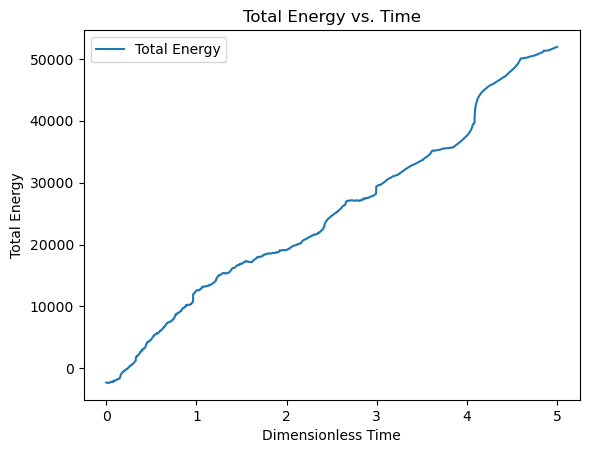

In [5]:
#Integration in 5 dimmesion and plotting total energy

import numpy as np
import matplotlib.pyplot as plt

# Define constants
c = 15
rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)

# Define NFW model functions
def rho(r):
    return np.where((r > 0), rho_0/(c*r*(1+c*r)**2), 0)

def phi(r):
    return np.where((r > 0), -(4*np.pi*rho_0*np.log(1+c*r))/(c**3*r), 0)

# Simulation parameters
num_particles = 1000
particle_mass = 1.0
r_unit = 1.0
rho_unit = 1.0
m_unit = 1.0
v_unit = 1.0

# Leapfrog integration parameters
time_step = 0.001
num_steps = int(5 / time_step)  # Integrate for 5 dimensionless time units

# Initialize particle positions and velocities
particles = np.random.rand(num_particles, 6)
spherical = particles[:, 0:3]
velocities = particles[:, 3:]
square_velocities = np.sum(velocities**2, axis=1)

# Arrays to store time and energy values
time_values = np.zeros(num_steps)
kinetic_energy_values = np.zeros(num_steps)
potential_energy_values = np.zeros(num_steps)

# Leapfrog integration loop
for step in range(num_steps):
    # Update positions
    spherical[:, 0] += velocities[:, 0] * time_step
    spherical[:, 1] += velocities[:, 1] * time_step
    spherical[:, 2] += velocities[:, 2] * time_step
    
    # Calculate gravitational acceleration
    r = spherical[:, 0]
    acc = -np.gradient(phi(r), r)
    
    # Update velocities
    velocities[:, 0] += acc * time_step
    velocities[:, 1] += acc * time_step
    velocities[:, 2] += acc * time_step
    
    # Calculate energies
    square_velocities = np.sum(velocities**2, axis=1)
    kinetic_energy = 0.5 * particle_mass * np.sum(square_velocities)
    potential_energy = particle_mass * np.sum(phi(r))
    
    # Store time and energy values
    time_values[step] = step * time_step
    kinetic_energy_values[step] = kinetic_energy
    potential_energy_values[step] = potential_energy

# Calculate total energy
total_energy_values = kinetic_energy_values + potential_energy_values

# Plot the results
plt.plot(time_values, total_energy_values, label='Total Energy')
plt.xlabel('Dimensionless Time')
plt.ylabel('Total Energy')
plt.title('Total Energy vs. Time')
plt.legend()
plt.show()


# 3.4 Evolution of an disk in an NFW halo

In [6]:
#NFW modewhen c=40
c = 40
rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
rho = lambda r : rho_0/(c*r*(1+c*r)**2)
phi = lambda r : -(4*np.pi*rho_0*np.log(1+c*r))/(c**3*r)

particles = nfw_model(num_particles)
spherical = particles[:,0:3]
velocities = particles[:,3:]
square_velocities = velocities[:,0]**2+velocities[:,1]**2+velocities[:,2]**2
cartesian = np.zeros((num_particles,3))
for i in range(num_particles):
  cartesian[i] = spherical_to_cartesian(spherical[i])
scaled_cartesian = cartesian*r_unit

num_bins = 1000
r_smooth = np.linspace(0,1,num_bins)[1:]

plt.hist(spherical[:,0],50,density=True,label='Acceptance-Rejection')
plt.plot(r_smooth,4*np.pi*r_smooth**2*rho(r_smooth),label='Expected')
plt.xlim((0,1))
plt.xlabel('r')
plt.ylabel(r'$4 \pi r^2 \rho (r)$')
plt.title('Radius Distribution (NFW)')
plt.legend()
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,8))
plot_model(ax1,scaled_cartesian[:,0],scaled_cartesian[:,1],'x (kpc)','y (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plot_model(ax2,scaled_cartesian[:,0],scaled_cartesian[:,2],'x (kpc)','z (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plot_model(ax3,scaled_cartesian[:,1],scaled_cartesian[:,2],'y (kpc)','z (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plt.show()

shell_densities = np.zeros(num_bins)
bins = np.linspace(0,1,num_bins+1)
radii = spherical[:,0]
for i in range(num_bins):
  inner_radius = bins[i]
  outer_radius = bins[i+1]
  num_particles_in_shell = len(np.where(radii[np.where(radii < outer_radius)[0]] >= inner_radius)[0])
  shell_densities[i] = num_particles_in_shell*particle_mass/(4/3*np.pi*(outer_radius**3-inner_radius**3))
scaled_shell_densities = shell_densities*rho_unit

plt.loglog(bins[:-1]*r_unit,scaled_shell_densities,label='Model')
plt.loglog(r_smooth*r_unit,rho(r_smooth)*rho_unit,label='Expected')
plt.xlim((bins[1]*r_unit,r_unit))
plt.xlabel('Radius (kpc)')
plt.ylabel('Density (M$_{\odot}$/kpc$^3$)')
plt.title('Density vs. Radius (NFW)')
plt.legend()
plt.show()

kinetic_energy = 0.5*particle_mass*m_unit*np.sum(square_velocities)*v_unit**2
potential_energy = particle_mass*m_unit*np.sum(phi(spherical[:,0]))*v_unit**2

print('Kinetic Energy: %.4e J'%(kinetic_energy*1.99e36))
print('Potential Energy: %.4e J'%(potential_energy*1.99e36))
print('2T/|W| = '+str(2*kinetic_energy/abs(potential_energy)))

NameError: name 'accept_reject_batch' is not defined

In [7]:
#integration of orbits 
def gravitational_force(r):
    # Calculate the gravitational force at a given position 'r'
    return -np.gradient(phi(r), r)

def update_positions_and_velocities(positions, velocities, dt):
    # Update positions and velocities using a simple numerical integration scheme
    accelerations = gravitational_force(positions[:, 0])  # Pass only the radial component for now
    velocities[:, 0] += accelerations * dt
    positions[:, 0] += velocities[:, 0] * dt
    return positions, velocities

# Initialize particle positions and velocities
positions = spherical[:, 0:3]
velocities = particles[:, 3:]

# Time parameters
t_final = 10.0  # Set your desired final time
dt = 0.01  # Set your desired time step

# Number of time steps
num_steps = int(t_final / dt)

# Perform numerical integration
for step in range(num_steps):
    positions, velocities = update_positions_and_velocities(positions, velocities, dt)



/tmp/ipykernel_2879/1419016064.py:5: RuntimeWarning: invalid value encountered in log
  phi = lambda r : -(4*np.pi*rho_0*np.log(1+c*r))/(c**3*r)


In [8]:
#disk moel and evolve it for 5 dimensionless time unit
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# Constants
c = 40
rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
rho = lambda r: rho_0/(c*r*(1+c*r)**2)
phi = lambda r: -(4*np.pi*rho_0*np.log(1+c*r))/(c**3*r)

# Function to generate NFW model
def nfw_model(num_particles):
    c = 15
    particle_mass = 1/num_particles
    particles = np.zeros((num_particles, 6))
    rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
    rho = lambda r : rho_0/(c*r*(1+c*r)**2)
    rng = np.random.default_rng()

    particles[:, 2] = rng.uniform(0, 2*np.pi, num_particles)
    particles[:, 1] = np.arccos(rng.uniform(-1,1,num_particles))
    particles[:, 0] = accept_reject_batch(0, 1, 0, rho(1/15), lambda r: 4*np.pi*r**2*rho(r), num_particles)

    nfw_velocity_table = np.loadtxt('NFW_dispersion.dat')
    velocity_interp = interpolate.interp1d(nfw_velocity_table[:, 0], nfw_velocity_table[:, 1], kind='linear', fill_value='extrapolate')
    velocity_dispersion = velocity_interp(particles[:, 0])
    particles[:, 3] = rng.normal(0, velocity_dispersion, num_particles)
    particles[:, 4] = rng.normal(0, velocity_dispersion, num_particles)
    particles[:, 5] = rng.normal(0, velocity_dispersion, num_particles)

    return particles

def gravitational_force(r):
    # Calculate the gravitational force at a given position 'r'
    return -np.gradient(phi(r), r)

def update_positions_and_velocities(positions, velocities, dt):
    # Update positions and velocities using a simple numerical integration scheme
    accelerations = gravitational_force(positions[:, 0])  # Pass only the radial component for now
    velocities[:, 0] += accelerations * dt
    positions[:, 0] += velocities[:, 0] * dt
    return positions, velocities

# Number of particles
num_particles = 1000

# Generate NFW model
particles = nfw_model(num_particles)
spherical = particles[:, 0:3]
velocities = particles[:, 3:]
square_velocities = velocities[:, 0]**2 + velocities[:, 1]**2 + velocities[:, 2]**2

# Initialize particle positions and velocities
positions = spherical[:, 0:3]
velocities = particles[:, 3:]

# Time parameters
t_final = 10.0  # Set your desired final time
dt = 0.01  # Set your desired time step

# Number of time steps
num_steps = int(t_final / dt)
r_smooth = np.linspace(0,1,num_bins)[1:]

plt.hist(spherical[:,0],50,density=True,label='Acceptance-Rejection')
plt.plot(r_smooth,4*np.pi*r_smooth**2*rho(r_smooth),label='Expected')
plt.xlim((0,1))
plt.xlabel('r')
plt.ylabel(r'$4 \pi r^2 \rho (r)$')
plt.title('Radius Distribution (NFW)')
plt.legend()
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,8))
plot_model(ax1,scaled_cartesian[:,0],scaled_cartesian[:,1],'x (kpc)','y (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plot_model(ax2,scaled_cartesian[:,0],scaled_cartesian[:,2],'x (kpc)','z (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plot_model(ax3,scaled_cartesian[:,1],scaled_cartesian[:,2],'y (kpc)','z (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plt.show()

# Perform numerical integration
for step in range(num_steps):
    positions, velocities = update_positions_and_velocities(positions, velocities, dt)

# Rest of your code for analysis and plotting
plt.loglog(bins[:-1]*r_unit,scaled_shell_densities,label='Model')
plt.loglog(r_smooth*r_unit,rho(r_smooth)*rho_unit,label='Expected')
plt.xlim((bins[1]*r_unit,r_unit))
plt.xlabel('Radius (kpc)')
plt.ylabel('Density (M$_{\odot}$/kpc$^3$)')
plt.title('Density vs. Radius (NFW)')
plt.legend()
plt.show()

kinetic_energy = 0.5*particle_mass*m_unit*np.sum(square_velocities)*v_unit**2
potential_energy = particle_mass*m_unit*np.sum(phi(spherical[:,0]))*v_unit**2

print('Kinetic Energy: %.4e J'%(kinetic_energy*1.99e36))
print('Potential Energy: %.4e J'%(potential_energy*1.99e36))
print('2T/|W| = '+str(2*kinetic_energy/abs(potential_energy)))

NameError: name 'accept_reject_batch' is not defined

# 3.5 Evolution of an disk in an NFW Halo with a galaxy encounter

In [9]:
# perturber moving in the disk plane with a velocity of 240km/s
# impact radius of 30kpc.


def nfw_model(num_particles):

  c = 15
  particle_mass = 1/num_particles
  particles = np.zeros((num_particles,6))
  rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
  rho = lambda r : rho_0/(c*r*(1+c*r)**2)
  rng = np.random.default_rng()

  particles[:,2] = rng.uniform(0, 2*np.pi, num_particles)
  particles[:,1] = np.arccos(rng.uniform(-1,1,num_particles))
  particles[:,0] = accept_reject_batch(0,1,0,rho(1/15),lambda r : 4*np.pi*r**2*rho(r),num_particles)

  nfw_velocity_table = np.loadtxt('NFW_dispersion.dat')
  velocity_interp = interp.interp1d(nfw_velocity_table[:,0],nfw_velocity_table[:,1],kind='linear',fill_value='extrapolate')
  velocity_dispersion = velocity_interp(particles[:,0])
  particles[:,3] = rng.normal(0,velocity_dispersion,num_particles)
  particles[:,4] = rng.normal(0,velocity_dispersion,num_particles)
  particles[:,5] = rng.normal(0,velocity_dispersion,num_particles)

  return particles



c = 15
rho_0 = (c**3)/(4*np.pi)*(np.log(1+c)-c/(1+c))**(-1)
rho = lambda r : rho_0/(c*r*(1+c*r)**2)
phi = lambda r : -(4*np.pi*rho_0*np.log(1+c*r))/(c**3*r)

particles = nfw_model(num_particles)
spherical = particles[:,0:3]
velocities = particles[:,3:]
square_velocities = velocities[:,0]**2+velocities[:,1]**2+velocities[:,2]**2
cartesian = np.zeros((num_particles,3))
for i in range(num_particles):
  cartesian[i] = spherical_to_cartesian(spherical[i])
scaled_cartesian = cartesian*r_unit

num_bins = 1000
r_smooth = np.linspace(0,1,num_bins)[1:]

plt.hist(spherical[:,0],50,density=True,label='Acceptance-Rejection')
plt.plot(r_smooth,4*np.pi*r_smooth**2*rho(r_smooth),label='Expected')
plt.xlim((0,1))
plt.xlabel('r')
plt.ylabel(r'$4 \pi r^2 \rho (r)$')
plt.title('Radius Distribution (NFW)')
plt.legend()
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,8))
plot_model(ax1,scaled_cartesian[:,0],scaled_cartesian[:,1],'x (kpc)','y (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plot_model(ax2,scaled_cartesian[:,0],scaled_cartesian[:,2],'x (kpc)','z (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plot_model(ax3,scaled_cartesian[:,1],scaled_cartesian[:,2],'y (kpc)','z (kpc)','Particle Distribution (NFW)',[-300,-200,-100,0,100,200,300],[-300,-200,-100,0,100,200,300])
plt.show()

shell_densities = np.zeros(num_bins)
bins = np.linspace(0,1,num_bins+1)
radii = spherical[:,0]
for i in range(num_bins):
  inner_radius = bins[i]
  outer_radius = bins[i+1]
  num_particles_in_shell = len(np.where(radii[np.where(radii < outer_radius)[0]] >= inner_radius)[0])
  shell_densities[i] = num_particles_in_shell*particle_mass/(4/3*np.pi*(outer_radius**3-inner_radius**3))
scaled_shell_densities = shell_densities*rho_unit

plt.loglog(bins[:-1]*r_unit,scaled_shell_densities,label='Model')
plt.loglog(r_smooth*r_unit,rho(r_smooth)*rho_unit,label='Expected')
plt.xlim((bins[1]*r_unit,r_unit))
plt.xlabel('Radius (kpc)')
plt.ylabel('Density (M$_{\odot}$/kpc$^3$)')
plt.title('Density vs. Radius (NFW)')
plt.legend()
plt.show()

kinetic_energy = 0.5*particle_mass*m_unit*np.sum(square_velocities)*v_unit**2
potential_energy = particle_mass*m_unit*np.sum(phi(spherical[:,0]))*v_unit**2

print('Kinetic Energy: %.4e J'%(kinetic_energy*1.99e36))
print('Potential Energy: %.4e J'%(potential_energy*1.99e36))
print('2T/|W| = '+str(2*kinetic_energy/abs(potential_energy)))

NameError: name 'accept_reject_batch' is not defined

In [22]:
def perturbed_nfw_model(num_particles, perturber_mass_fraction=0.5, perturber_position=(900, 30, 0), perturber_velocity=(240, 0, 0), impact_radius=30):
    c = 15
    particle_mass = 1 / num_particles
    perturber_mass = perturber_mass_fraction / num_particles
    particles = np.zeros((num_particles, 6))
    perturber_position = np.array(perturber_position)
    perturber_velocity = np.array(perturber_velocity)

    # Constants for the unperturbed NFW model
    rho_0 = (c ** 3) / (4 * np.pi) * (np.log(1 + c) - c / (1 + c)) ** (-1)
    rho = lambda r: rho_0 / (c * r * (1 + c * r) ** 2)
    rng = np.random.default_rng()

    # Generate particle positions in spherical coordinates
    particles[:, 2] = rng.uniform(0, 2 * np.pi, num_particles)
    particles[:, 1] = np.arccos(rng.uniform(-1, 1, num_particles))
    particles[:, 0] = accept_reject_batch(0, 1, 0, rho(1 / 15), lambda r: 4 * np.pi * r ** 2 * rho(r), num_particles)

    # Load velocity dispersion data for the unperturbed NFW model
    nfw_velocity_table = np.loadtxt('NFW_dispersion.dat')
    velocity_interp = interp.interp1d(nfw_velocity_table[:, 0], nfw_velocity_table[:, 1], kind='linear', fill_value='extrapolate')
    velocity_dispersion = velocity_interp(particles[:, 0])

    # Generate velocities for the particles based on the unperturbed NFW model
    particles[:, 3] = rng.normal(0, velocity_dispersion, num_particles)
    particles[:, 4] = rng.normal(0, velocity_dispersion, num_particles)
    particles[:, 5] = rng.normal(0, velocity_dispersion, num_particles)

    # Evolve the system, including the perturbing halo
    dt = 0.01  # Time step (you may need to adjust this)
    num_steps = 1000  # Number of time steps (you may need to adjust this)
    for step in range(num_steps):
        # Update particle positions
        spherical_positions = particles[:, 0:3]
        cartesian_positions = spherical_to_cartesian(spherical_positions)
        particles[:, 0:3] = cartesian_to_spherical(cartesian_positions)

        # Update particle velocities based on the perturbing halo
        perturber_distance = np.linalg.norm(cartesian_positions - perturber_position, axis=1)
        perturber_force = -particle_mass * perturber_mass / perturber_distance ** 3 * (cartesian_positions - perturber_position)
        particles[:, 3:6] += perturber_force * dt

    return particles
